In [3]:
# initialize packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import tplquad
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm import tqdm

# 1

100%|██████████| 1000/1000 [1:46:25<00:00,  6.39s/it]


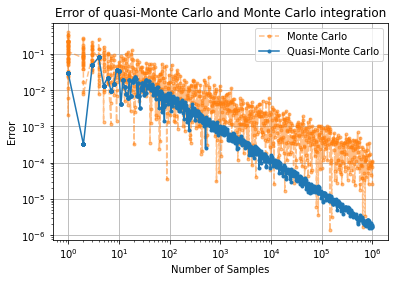

In [77]:
def halton(n,b):
    """
    Compute the Halton sequence for the given number of elements and base.
    Args:
        n: The number of elements in the sequence.
        b: The base to use for the Halton sequence.
    Returns:
        The computed Halton sequence of length n.
    """
    # Create an array of zeros with length n and store it in the variable h
    h = np.zeros(n)
    p = 1./b
    # Loop through n elements
    for i in range(n):
        h[i] = 0
        f = p
        j = i+1
        while j > 0:
            h[i] += f*(j%b)
            j = np.floor(j/b)
            f = f/b
    return h

def f(x,y,z):
    """
    The function to integrate.
    Args:
        x: The x coordinate.
        y: The y coordinate.
        z: The z coordinate.
    Returns:
        The value of the function at the given coordinates.
    """
    return x*y/np.sqrt(x**2 + y**2 + z**2)

def qmc(n):
    """
    Compute the quasi-Monte Carlo integration of the function f.
    Args:
        n: The number of samples to use for the integration.
    Returns:
        The computed value of the integration.
    """
    # Halton sequence with bases 2, 3 and 5 respectively.
    x = halton(n,2)
    y = halton(n,3)
    z = halton(n,5)
    return np.sum(f(x,y,z))/n

def mc(n):
    """
    Compute the Monte Carlo integration of the function f.
    Args:
        n: The number of samples to use for the integration.
    Returns:
        The computed value of the integration.
    """
    x = np.random.uniform(0,1,n)
    y = np.random.uniform(0,1,n)
    z = np.random.uniform(0,1,n)
    return np.sum(f(x,y,z))/n

n = np.logspace(0,6,1000, dtype='int')
qmc_err = []
mc_err = []
for i in tqdm(n):
    qmc_err.append(np.abs(qmc(i)-tplquad(f,0,1,0,1,0,1)[0]))
    mc_err.append(np.abs(mc(i)-tplquad(f,0,1,0,1,0,1)[0]))

plt.figure()
plt.loglog(n,mc_err,label='Monte Carlo', color='C1', linestyle='--', alpha=0.5,marker='o', markersize=3)
plt.loglog(n,qmc_err,label='Quasi-Monte Carlo', color='C0', marker='o', markersize=3)
plt.xlabel('Number of Samples')
plt.ylabel('Error')
plt.legend()

# Add a title and a grid to the figure.
plt.title('Error of quasi-Monte Carlo and Monte Carlo integration')
plt.grid(True)

plt.show()

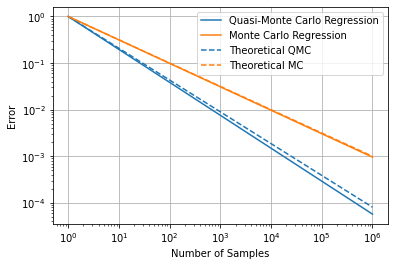

In [78]:
# Polynomial curve fitting of degree 1
qmc_fit = np.polyfit(np.log(n), np.log(qmc_err), 1)
mc_fit = np.polyfit(np.log(n), np.log(mc_err), 1)

qmc_slope = qmc_fit[0]
qmc_intercept = qmc_fit[1]

mc_slope = mc_fit[0]
mc_intercept = mc_fit[1]

# Convergence rate comparison
plt.loglog(n,np.power(n, qmc_slope),color='C0', label='Quasi-Monte Carlo Regression')
plt.loglog(n,np.power(n, mc_slope),color='C1', label='Monte Carlo Regression')
plt.loglog(n,np.power(n, -0.68191),'--',color='C0', label='Theoretical QMC')
plt.loglog(n,np.power(n, -1/2),'--',color='C1', label='Theoretical MC')
plt.xlabel('Number of Samples')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.show()

# 2

In [40]:
def target(x):
    """
    Evaluate the target distribution at the given point x.
    Args:
        x: The point at which to evaluate the target distribution.
    Returns:
        The value of the target distribution at the given point x.
    """
    return x**3 * np.sin(np.pi * x)/ (2 / np.pi - 12 / np.pi**3)

def proposal(x, y, sigma):
    """
    Generate a proposal point y using a normal distribution centered at x.
    Args:
        x: The center of the normal distribution.
        y: The point at which to evaluate the proposal distribution.
        sigma: The standard deviation of the normal distribution.
    Returns:
        A proposal point y generated using the given normal distribution.
    """
    return 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(y - x)**2 / (2 * sigma**2))
def metropolis_hastings(n_samples, sigma):
    """
    Generate a sequence of samples using the Metropolis-Hastings algorithm.
    args:
    n_samples: The number of samples to generate.
    sigma: The standard deviation of the normal distribution used as the proposal distribution.
    Returns:
    samples: A 1-D array of samples.
    """
    # Initialize an empty list to store the samples
    samples = []
    x = 0 # start from x = 0
    # Calculate the constant C
    C = 2 * np.pi - 1 / 2 * np.pi**3
    # Loop through the number of samples
    for i in range(n_samples):
        # Generate a proposal point y using a normal distribution centered at x with standard deviation sigma
        y = np.random.normal(x, sigma)
        # Calculate the acceptance probability
        acceptance_probability = target(y) / (target(x) + 1e-10) * proposal(x, y, sigma) / (proposal(y, x, sigma)+ 1e-10)
        # If the acceptance probability is greater than or equal to 1, accept the proposal point y
        if acceptance_probability >= 1:
            x = y
            samples.append(x)
        # If the acceptance probability is less than 1, use a random uniform value to determine whether to accept or reject the proposal point y
        else:
            u = np.random.uniform()
            if u < acceptance_probability:
                x = y
                samples.append(x)
            else:
                samples.append(x)
     # Return the samples
    return np.array(samples)

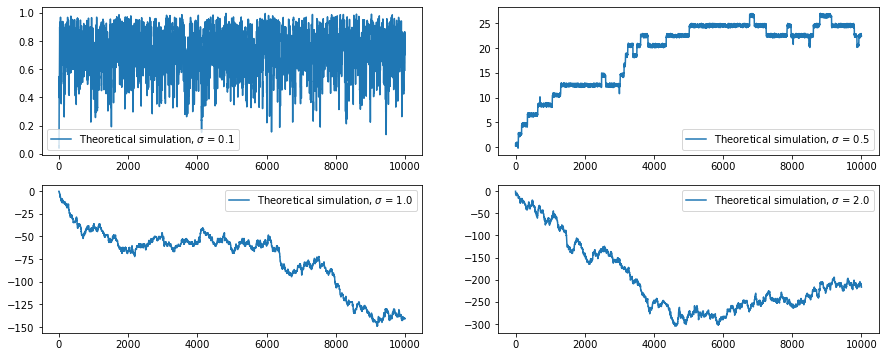

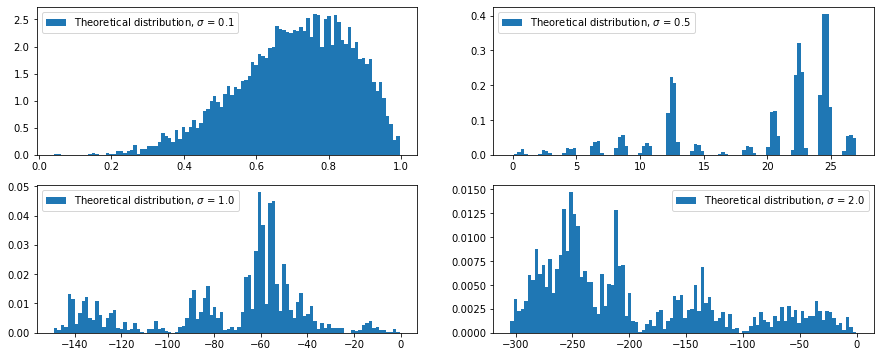

In [41]:
# Set the number of samples and the variance of the normal distribution.
n_samples = 10000
random_seed = 1
# Set the values of sigma to use.
sigmas = [0.1, 0.5, 1.0, 2.0]
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig1, axs1 = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
axs1 = axs1.ravel()
j=0
# Generate a sample for each value of sigma, and plot the resulting histogram.
for sigma in sigmas:
    # Initialize the sample array and the starting point.
    sample = np.zeros(n_samples)
    # Generate the sample using the Metropolis-Hastings algorithm.
    sample = metropolis_hastings(n_samples, sigma)
    # Plot the simulation of the sample.
    axs[j].plot(range(len(sample)),sample)
    axs[j].legend(['Theoretical simulation, $\sigma$ = '+ str(sigma)])
    axs1[j].hist(sample, bins=100, density=True)
    axs1[j].legend(['Theoretical distribution, $\sigma$ = '+ str(sigma)])
    j+=1

# 3

### (a)

In [83]:
# parameters
S0 = 130
r = 0.02
sigma = 0.2
T = 0.5
M = 1000000

# simulate stock price at expiration
z = np.random.standard_normal(M)
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * z)

# calculate European put option prices
Ks = [120, 130, 140]
put_price = np.zeros((M, len(Ks)))
for i in range(M):
    for j, k in enumerate(Ks):
        put_price[i, j] = max(k - ST[i], 0)

# estimate delta and vega using Monte Carlo simulation
deltas = np.zeros((M, len(Ks)))
vegas = np.zeros((M, len(Ks)))
for i in range(M):
    for j, k in enumerate(Ks):
        if ST[i]<k:
            vegas[i, j] = -np.exp(-r*T)*(-sigma*T+np.sqrt(T)*z[i])*ST[i]
            deltas[i, j] = -np.exp(-r*T)*ST[i]/S0
vegas = vegas.mean(axis=0)
deltas = deltas.mean(axis=0)

# output
print("European puy option prices:")
for i, k in enumerate(Ks):
    print("K = %d: %.6f" % (k, put_price[:,i].mean()))
    
print("\nEuropean put option deltas:")
for i, k in enumerate(Ks):
    print("K = %d: %.6f" % (k, deltas[i]))

print("\nEuropean put option vegas:")
for i, k in enumerate(Ks):
    print("K = %d: %.6f" % (k, vegas[i]))


European puy option prices:
K = 120: 2.817429
K = 130: 6.730186
K = 140: 12.762675

European put option deltas:
K = 120: -0.239712
K = 130: -0.443533
K = 140: -0.648515

European put option vegas:
K = 120: 28.566528
K = 130: 36.303493
K = 140: 34.090829


### (b)

In [84]:
# Parameters
S0 = 130
r = 0.02
sigma = 0.2
T = 0.5
M = 1000000
monitoring_dates = 6
dt = T / monitoring_dates

S = np.zeros((monitoring_dates+1,M))
S[0,:] = S0
# Simulation
z = np.random.standard_normal((monitoring_dates+1,M))
for i in range(0,monitoring_dates):
    S[i+1] = S[i] * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(dt) * z[i])
# Calculate average stock price over the six months
S_avg = S[1:,:].mean(axis=0) # Removing S0
dSdSigma = S * np.log(S / S0 - (r + 0.5 * sigma ** 2) * dt) / sigma
# Calculate option prices
Ks = [120, 130, 140]
put_price = np.zeros((M, len(Ks)))
for i in range(M):
    for j, k in enumerate(Ks):
        put_price[i, j] = max(k - S_avg[i], 0)
deltas = np.zeros((M, len(Ks)))
vegas = np.zeros((M, len(Ks)))
for i in range(M):
    for j, k in enumerate(Ks):
        if S_avg[i]<k:
            vegas[i, j] = -np.exp(-r*T)*np.mean(dSdSigma[:,i])
            deltas[i, j] = -np.exp(-r*T)*S_avg[i]/S0
vegas = vegas.mean(axis=0)
deltas = deltas.mean(axis=0)

# output
print("Arithmetic Asian put prices:")
for i, k in enumerate(Ks):
    print("K = %d: %.6f" % (k, put_price[:,i].mean()))
    
print("Arithmetic Asian put option deltas:")
for i, k in enumerate(Ks):
    print("K = %d: %.6f" % (k, deltas[i]))

print("\nArithmetic Asian put option vegas:")
for i, k in enumerate(Ks):
    print("K = %d: %.6f" % (k, vegas[i]))


Arithmetic Asian put prices:
K = 120: 1.069633
K = 130: 4.406525
K = 140: 10.906453
Arithmetic Asian put option deltas:
K = 120: -0.162836
K = 130: -0.457106
K = 140: -0.754900

Arithmetic Asian put option vegas:
K = 120: 11.815700
K = 130: 18.339488
K = 140: 12.855311


### (c)

In [85]:
# parameters
S0 = 130
r = 0.02
sigma = 0.2
T = 0.5
M = 1000000

# simulate stock price at expiration
z = np.random.standard_normal(M)
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * z)

# calculate digital option prices
Ks = [120, 130, 140]
digital_price = np.zeros((M, len(Ks)))
for i in range(M):
    for j, k in enumerate(Ks):
        digital_price[i, j] = 10 if k - ST[i] > 0 else 0

# estimate delta and vega using Monte Carlo simulation
deltas = np.zeros((M, len(Ks)))
vegas = np.zeros((M, len(Ks)))
for i in range(M):
    for j, k in enumerate(Ks):
        if ST[i]<k:
            vegas[i, j] = -np.exp(-r*T)*(-sigma*T+np.sqrt(T)*z[i])*ST[i]
            deltas[i, j] = -np.exp(-r*T)*ST[i]/S0
vegas = vegas.mean(axis=0)
deltas = deltas.mean(axis=0)

# output
print("Digital option prices:")
for i, k in enumerate(Ks):
    print("K = %d: %.6f" % (k, digital_price[:,i].mean()))
    
print("\nDigital option deltas:")
for i, k in enumerate(Ks):
    print("K = %d: %.6f" % (k, deltas[i]))

print("\nDigital option vegas:")
for i, k in enumerate(Ks):
    print("K = %d: %.6f" % (k, vegas[i]))

Digital option prices:
K = 120: 2.859980
K = 130: 5.000080
K = 140: 6.997680

Digital option deltas:
K = 120: -0.239898
K = 130: -0.443731
K = 140: -0.648864

Digital option vegas:
K = 120: 28.586623
K = 130: 36.332276
K = 140: 34.095768


# 4

In [91]:
def LSMC_Bermuda_Call(S0, K, r, T, sigma, M, N, poly_degree):
    """
    This function calculates the price of a Bermuda call option using the Least-Squares Monte Carlo (LSMC) method.
    Args:
    S0 : The initial price of the underlying asset.
    K : The strike price of the option.
    r : The risk-free interest rate.
    T : The time to expiration of the option, in years.
    sigma : The volatility of the underlying asset.
    M : The number of Monte Carlo simulations to run.
    N : The number of time steps to divide the simulation into.
    poly_degree The degree of the polynomial used in the LSMC method.
    
    Returns:
    price : The estimated price of the Bermuda call option.
    """
    #np.random.seed(random_seed)
    # Calculate the time step size
    dt = T / N
    # Generate matrix of brownian motions
    dW = np.random.standard_normal((M, N + 1))*np.sqrt(dt)
    # Calculate asset price at each time step using the Euler-Maruyama method
    S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * dW,axis=1))
    S[:, 0] = S0
    # Initialize matrix to store option values at each time step
    V = np.zeros((M,N+1))
    # Calculate option values at maturity
    C = np.maximum(S - K, 0)
    V[:, -1] = C[:, -1]
    # Iterate backwards through time steps
    for t in range(N - 1, 0, -1):
        # Fit polynomial to asset prices and discounted future option values
        Lambdas = np.polyfit(S[:, t], V[:, t + 1] * np.exp(-r * dt), poly_degree)
        # Calculate expected future option values using fitted polynomial
        h = np.zeros(M)
        for i in range(M):
            h[i] = 0
            for j in range(poly_degree+1):
                h[i] += Lambdas[j]*S[i, t]**(poly_degree-j)
        # Update option values using optimal exercise decision
        for i in range(M):
            if C[i, t] > h[i]:
                V[i, t] = C[i, t]
            else:
                V[i, t] = V[i, t + 1] * np.exp(-r * dt)
    # Calculate average option value at time t=0
    price = np.mean(V[:, 1] * np.exp(-r * dt))
    return price

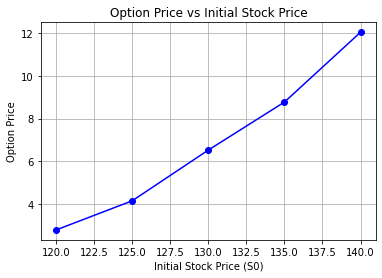

In [96]:
random_seed = 1
S0 = [120,125,130,135,140]
K = 135
r = 0.02
sigma = 0.2
T = 0.5
N = int(12 * 0.5)
M = 10000
dt = T / N
poly_degree=5
price = np.zeros(len(S0))
for i in range(len(S0)):
    price[i] = LSMC_Bermuda_Call(S0[i], K, r, T, sigma, M, N, poly_degree)
# Add x and y labels and a title
plt.xlabel('Initial Stock Price (S0)')
plt.ylabel('Option Price')
plt.title('Option Price vs Initial Stock Price')

# Add a grid
plt.grid(True)

# Plot the data
plt.plot(S0, price, 'o-', color='blue')

# Show the plot
plt.show()

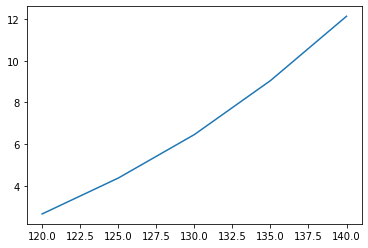